In [18]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.config.settings import FUNK_SVD_MODEL_DIR
from src.data.load_dataset import get_train_data, get_test_data, get_games_data
from src.evaluation.metrics import evaluate_recommendations
from src.models.recommender import GameRecommender
from src.models.funk_svd import FunkSVD


In [19]:
# Load data and initialize recommender
train_data = get_train_data()
test_data = get_test_data()
games_data = get_games_data()
print(f"Training: {len(train_data)} samples from {len(np.unique(train_data['UserId']))} users")
print(f"Testing: {len(test_data)} samples from {len(np.unique(test_data['UserId']))} users")

instance = GameRecommender(train_data, test_data, games_data)
instance.load(FUNK_SVD_MODEL_DIR)

Training: 81142 samples from 960 users
Testing: 18858 samples from 885 users


2025-05-08 00:49:39.643 | DEBUG    | src.models.funk_svd:load_model:308 - Loading models from C:\Ukma\coursework\funk-svd\data\models\funk_svd


In [20]:
pprint(evaluate_recommendations(instance.model, train_data))

{'ndcg': {10: np.float64(0.6555484379312698),
          20: np.float64(0.7202525473651703)},
 'precision': {10: 0.9131249999999966, 20: 0.8668399321463874},
 'recall': {10: 0.30852363204130945, 20: 0.5516067141845322}}


In [21]:
def analyze_user_predictions(user_id):
    user_id = int(user_id)

    user_test_items = test_data[test_data['UserId'] == user_id]
    if user_test_items.empty:
        return pd.DataFrame()

    item_ids = user_test_items['BGGId'].astype(int).tolist()
    predictions = instance.get_predictions(user_id, item_ids)

    results = []
    for _, item in user_test_items.iterrows():
        item_id = int(item['BGGId'])
        if item_id in predictions:
            results.append({
                'ItemId': item_id,
                'Actual': float(item['Rating']),
                'Predicted': float(predictions[item_id]),
                'Error': float(item['Rating']) - float(predictions[item_id])
            })

    return pd.DataFrame(results)


def analyze_users(max_users=100):
    """Analyze a sample of users - only predictions, no recommendations"""
    test_user_ids = test_data['UserId'].unique()

    if len(test_user_ids) > max_users:
        np.random.seed(42)
        test_user_ids = np.random.choice(test_user_ids, max_users, replace=False)

    results = []
    for user_id in test_user_ids:
        predictions_df = analyze_user_predictions(user_id)
        if not predictions_df.empty:
            predictions_df['UserId'] = user_id
            results.append(predictions_df)

    return pd.concat(results) if results else pd.DataFrame()


In [41]:
def plot_predictions(df, title):
    """Plot actual vs predicted ratings"""
    plt.figure(figsize=(8, 6))
    plt.scatter(df['Actual'], df['Predicted'], alpha=0.1)
    plt.plot([1, 10], [1, 10], 'r--')
    plt.xlabel('Actual Rating')
    plt.ylabel('Predicted Rating')
    plt.title(title)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_error_distribution(df):
    """Plot distribution of prediction errors"""
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Error'], bins=20, kde=True)
    plt.axvline(0, color='r', linestyle='--')
    plt.title('Distribution of Prediction Errors')
    plt.xlabel('Error (Actual - Predicted)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


Prediction Results:
    ItemId  Actual  Predicted     Error
0   128621     8.0   7.332043  0.667957
1    58281     7.0   7.105896 -0.105896
2   210296     7.0   7.364217 -0.364217
3   188834     6.0   7.183442 -1.183442
4    34635     6.1   7.254538 -1.154538
..     ...     ...        ...       ...
78  245934     7.4   7.590772 -0.190772
79   28720     7.0   7.900607 -0.900607
80  133473     6.0   6.563980 -0.563980
81      12     7.0   7.447680 -0.447680
82  163967     7.2   6.955029  0.244971

[83 rows x 4 columns]


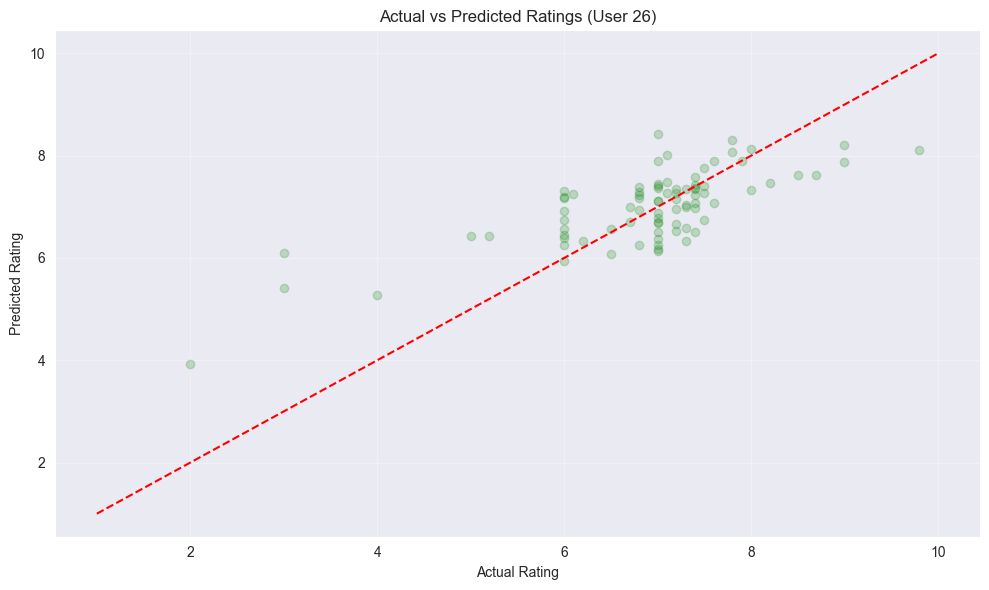

In [23]:
user_id = train_data['UserId'][0]
prediction_df = analyze_user_predictions(user_id)

print("Prediction Results:")
print(prediction_df)

plot_predictions(prediction_df, f'Actual vs Predicted Ratings (User {user_id})')

In [24]:
detailed_recs = instance.get_recommendations(user_id, n=10,
                                             attributes=['Name', 'YearPublished', 'AvgRating', 'NumUserRatings',
                                                            'Rank:boardgame'])
pd.DataFrame(detailed_recs)

,BGGId,PredictedRating,Name,YearPublished,AvgRating,NumUserRatings,Rank:boardgame
0,266507,8.611021,Clank!: Legacy – Acquisitions Incorporated,2019,8.69604,4722,34
1,246900,8.556355,Eclipse: Second Dawn for the Galaxy,2020,8.67526,4996,46
2,169427,8.545512,Middara: Unintentional Malum – Act 1,2019,8.84724,1544,545
3,270633,8.473934,Aeon's End: The New Age,2019,8.67759,1725,376
4,284378,8.421302,Kanban EV,2020,8.62853,2791,139
5,281655,8.391039,High Frontier 4 All,2020,8.57342,748,1308
6,255984,8.356949,Sleeping Gods,2021,8.51042,2496,237
7,161936,8.337600,Pandemic Legacy: Season 1,2015,8.59678,44614,2
8,291457,8.329487,Gloomhaven: Jaws of the Lion,2020,8.69610,15062,6
9,55690,8.309934,Kingdom Death: Monster,2015,8.61012,8012,50


In [25]:
print("Analyzing sample of users...")
all_predictions_df = analyze_users(max_users=10000)


Analyzing sample of users...


In [26]:
rmse = np.sqrt((all_predictions_df['Error'] ** 2).mean())
mae = all_predictions_df['Error'].abs().mean()
corr = np.corrcoef(all_predictions_df['Actual'], all_predictions_df['Predicted'])[0, 1]

print(f"Performance Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"Correlation: {corr:.4f}")


Performance Metrics:
RMSE: 1.1644
MAE: 0.8742
Correlation: 0.6000


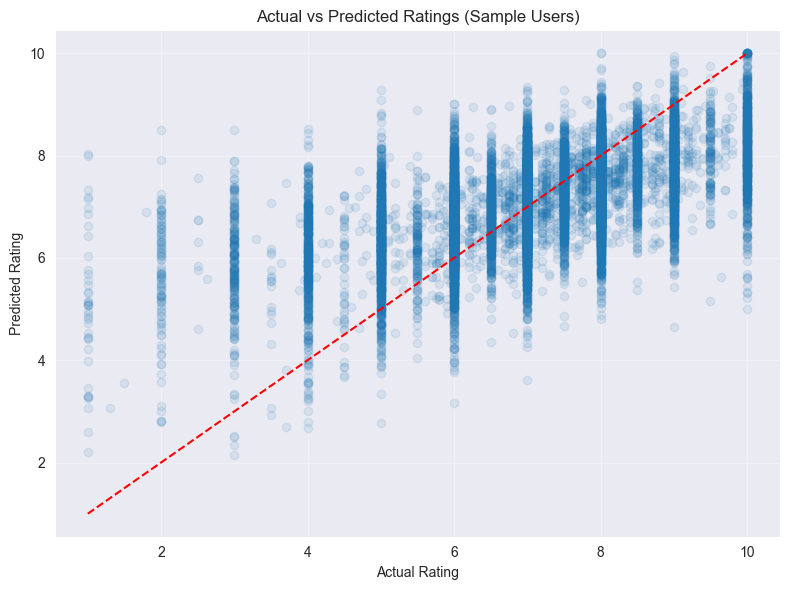

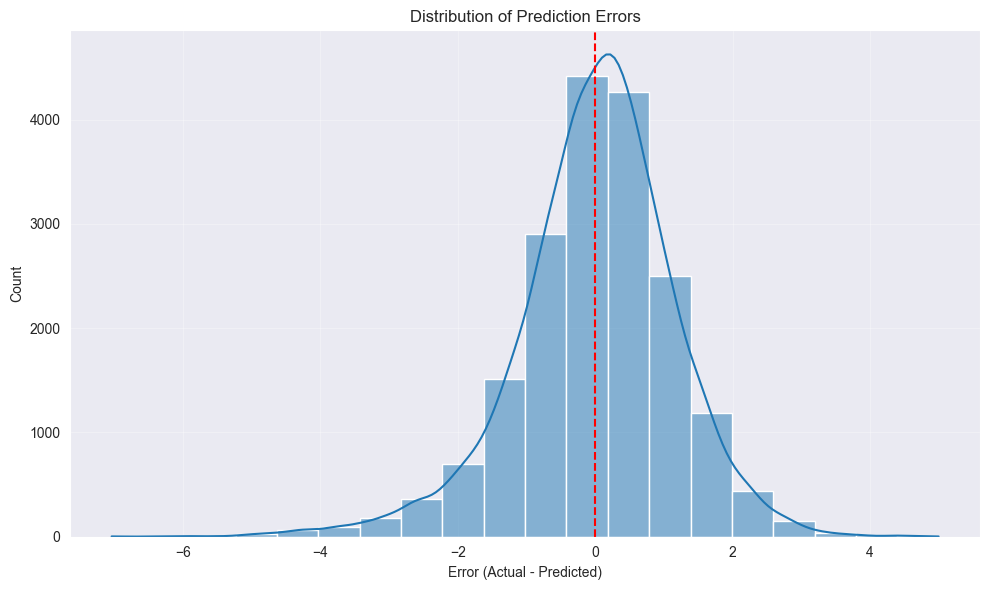

In [42]:
plot_predictions(all_predictions_df, 'Actual vs Predicted Ratings (Sample Users)')
plot_error_distribution(all_predictions_df)


In [28]:
popular_items = instance.get_popular_recommendations(train_data, 10)
popular_df = pd.DataFrame(popular_items, columns=['ItemId', 'Score'])

print("Popular Recommendations:")
print(popular_df)

personal_recs = instance.get_recommendations(user_id)
personal_rec_ids = [rec['BGGId'] for rec in personal_recs]
overlap = len(set(personal_rec_ids).intersection(set(popular_df['ItemId'])))

print(f"\nUser {user_id} Recommendations:")
print(pd.DataFrame(personal_recs))
print(f"\nOverlap with popular items: {overlap} items")


Popular Recommendations:
   ItemId      Score
0  167791  46.576445
1   68448  45.071618
2   30549  44.883919
3  169786  44.804702
4     822  44.289854
5  173346  43.926876
6  161936  43.883380
7  174430  43.710994
8   84876  43.657031
9    3076  43.338779

User 26 Recommendations:
    BGGId  PredictedRating
0  266507         8.611021
1  246900         8.556355
2  169427         8.545512
3  270633         8.473934
4  284378         8.421302
5  281655         8.391039
6  255984         8.356949
7  161936         8.337600
8  291457         8.329487
9   55690         8.309934

Overlap with popular items: 1 items


In [29]:
def plot_learning_curves(model):
    learning_data = model.get_learning_curves()
    
    for factor in learning_data['train'].keys():
        plt.figure(figsize=(12, 5))
        
        plt.plot(learning_data['train'][factor], label='Train RMSE', color='blue')
        
        if factor in learning_data['test'] and learning_data['test'][factor]:
            plt.plot(learning_data['test'][factor], label='Test RMSE', color='red')
        
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.title(f'Learning Curves - Factor {factor}')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


2025-05-08 00:49:46.365 | INFO     | src.models.funk_svd:fit:127 - Epoch 0, factor=0, Train RMSE=1.3119, Test RMSE=1.3066
2025-05-08 00:49:47.608 | INFO     | src.models.funk_svd:fit:127 - Epoch 1, factor=0, Train RMSE=1.2617, Test RMSE=1.2633
2025-05-08 00:49:48.924 | INFO     | src.models.funk_svd:fit:127 - Epoch 2, factor=0, Train RMSE=1.2350, Test RMSE=1.2419
2025-05-08 00:49:50.146 | INFO     | src.models.funk_svd:fit:127 - Epoch 3, factor=0, Train RMSE=1.2174, Test RMSE=1.2287
2025-05-08 00:49:51.365 | INFO     | src.models.funk_svd:fit:127 - Epoch 4, factor=0, Train RMSE=1.2043, Test RMSE=1.2193
2025-05-08 00:49:52.588 | INFO     | src.models.funk_svd:fit:127 - Epoch 5, factor=0, Train RMSE=1.1940, Test RMSE=1.2122
2025-05-08 00:49:53.887 | INFO     | src.models.funk_svd:fit:127 - Epoch 6, factor=0, Train RMSE=1.1853, Test RMSE=1.2066
2025-05-08 00:49:55.125 | INFO     | src.models.funk_svd:fit:127 - Epoch 7, factor=0, Train RMSE=1.1780, Test RMSE=1.2019
2025-05-08 00:49:56.359 

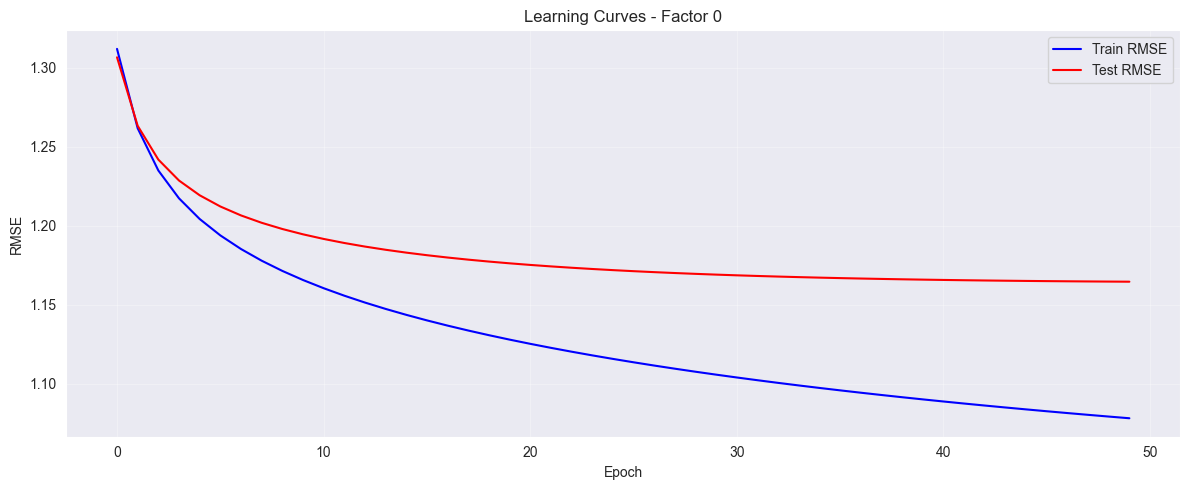

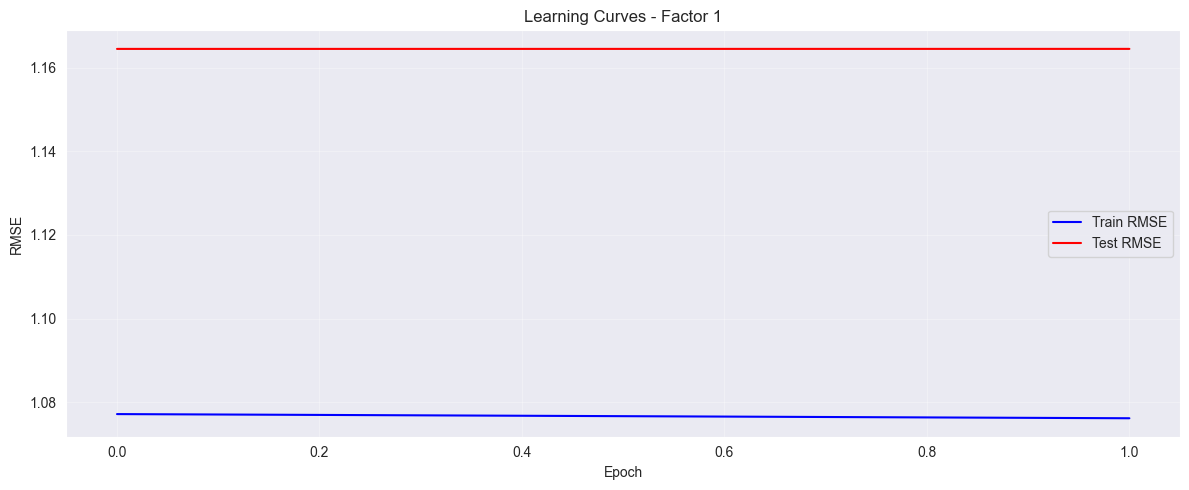

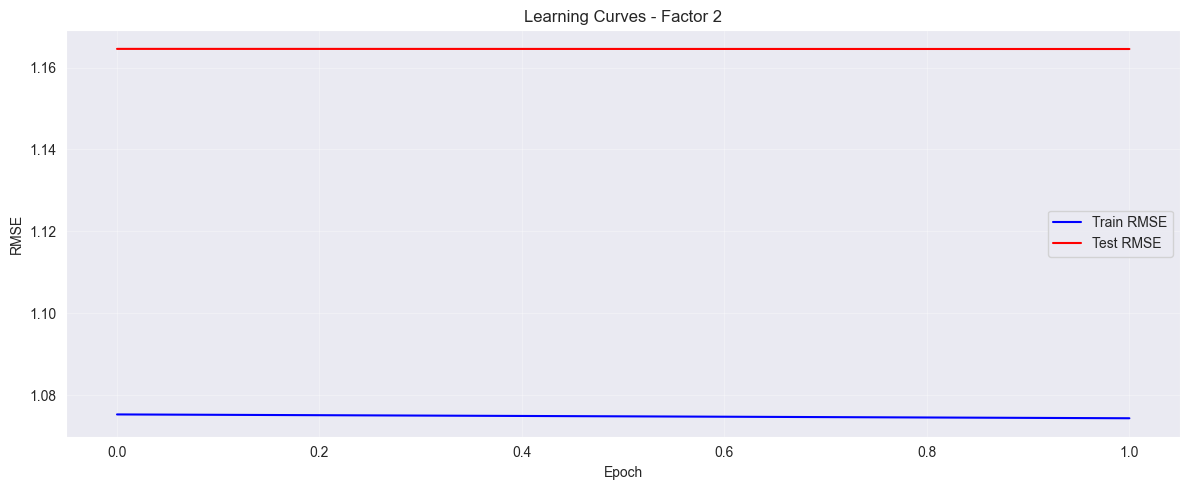

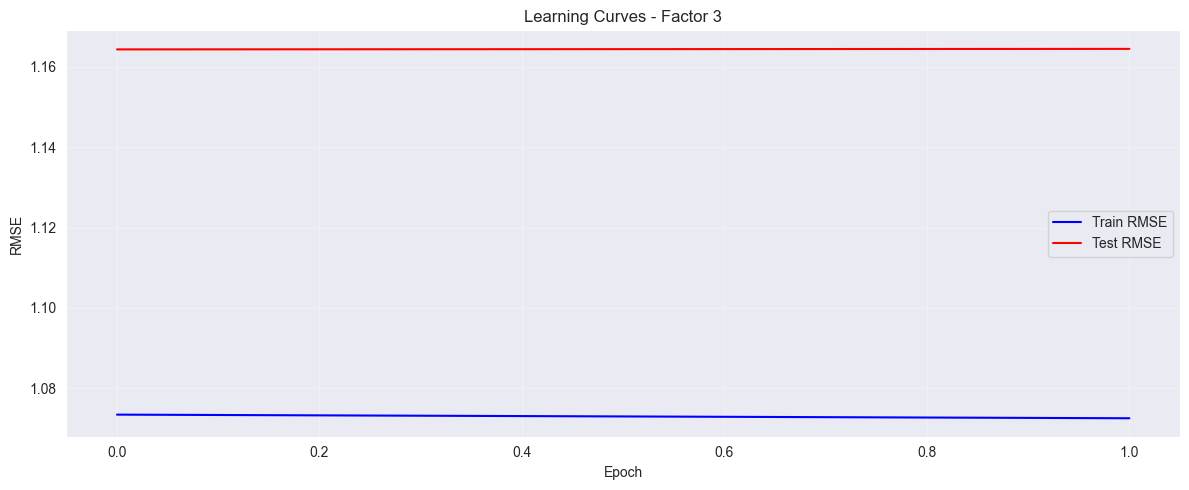

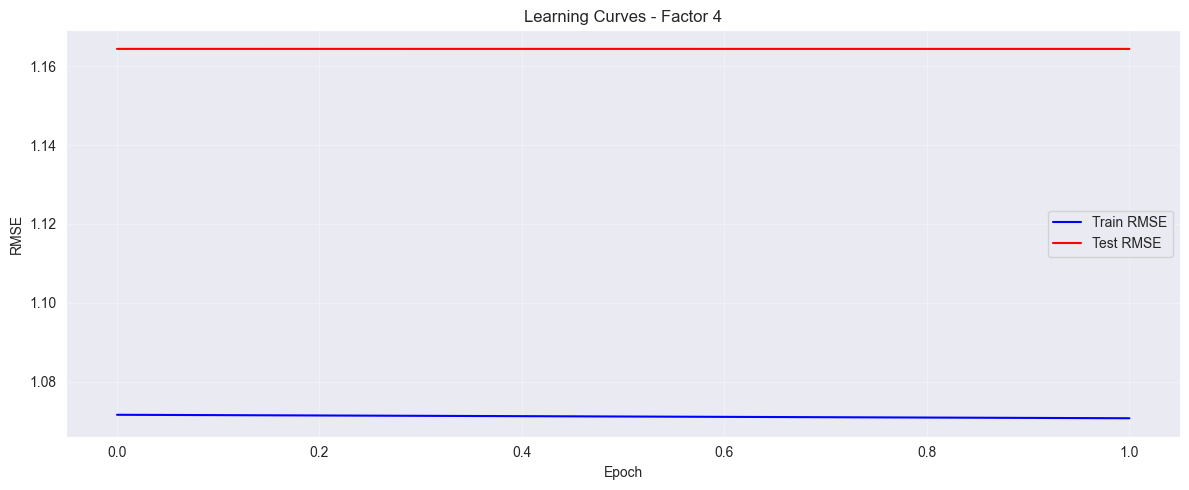

In [30]:
model = FunkSVD()
model.fit(train_data, test_data)
plot_learning_curves(model)


In [31]:
def calculate_diversity(recommendations, n=10):
    """Calculate diversity as the percentage of unique items across all user recommendations"""
    all_rec_items = set()
    total_recs = 0

    for user_id in np.random.choice(test_data['UserId'].unique(), 100):
        try:
            recs = instance.get_recommendations(user_id, n=n)
            rec_ids = [r['BGGId'] for r in recs]
            all_rec_items.update(rec_ids)
            total_recs += len(rec_ids)
        except:
            continue

    return len(all_rec_items) / total_recs if total_recs > 0 else 0

diversity_score = calculate_diversity(instance.get_recommendations, n=10)
print(f"Recommendation diversity score: {diversity_score:.4f}")

Recommendation diversity score: 0.0280


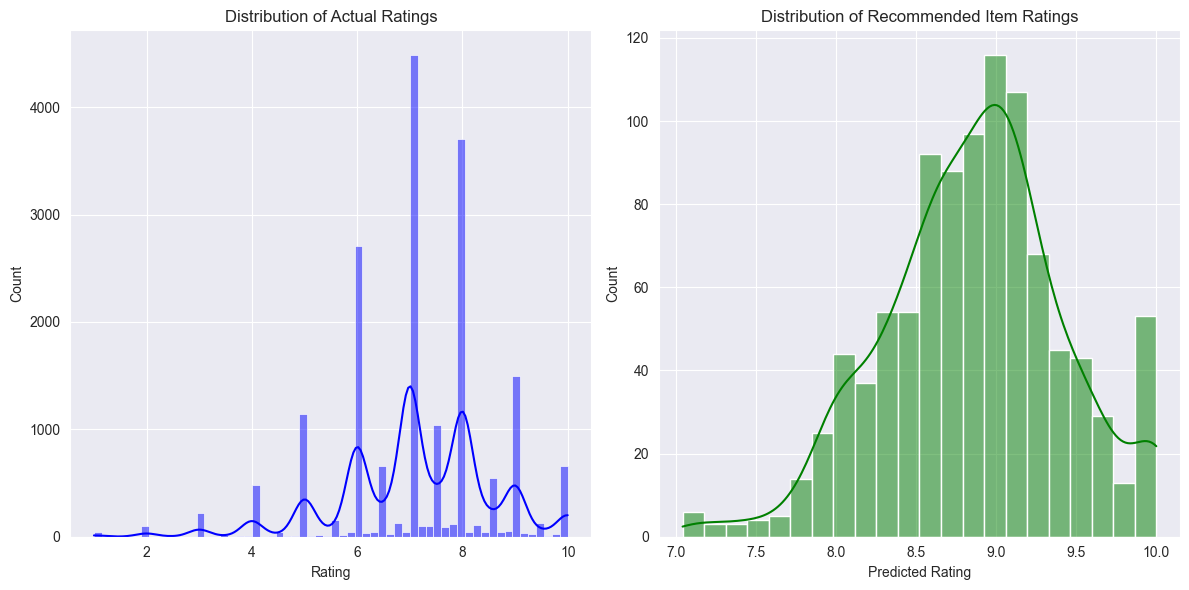

In [32]:
def analyze_recommendation_distributions(n_users=100):
    """Compare distributions of actual ratings vs recommendations"""
    users = np.random.choice(test_data['UserId'].unique(), min(n_users, len(test_data['UserId'].unique())))

    # Get recommendations for sample users
    rec_ratings = []
    for user_id in users:
        try:
            recs = instance.get_recommendations(user_id, n=10)
            rec_ratings.extend([r['PredictedRating'] for r in recs])
        except:
            continue

    # Get actual ratings distribution
    actual_ratings = test_data['Rating'].values

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(actual_ratings, kde=True, color='blue')
    plt.title('Distribution of Actual Ratings')
    plt.xlabel('Rating')

    plt.subplot(1, 2, 2)
    sns.histplot(rec_ratings, kde=True, color='green')
    plt.title('Distribution of Recommended Item Ratings')
    plt.xlabel('Predicted Rating')

    plt.tight_layout()
    plt.show()

analyze_recommendation_distributions()

  Segment  Precision@10  Recall@10   NDCG@10
0     Low      0.800526   1.000000  0.888393
1  Medium      0.803275   0.859701  0.800169
2    High      0.834076   0.388635  0.643805


<Figure size 1000x600 with 0 Axes>

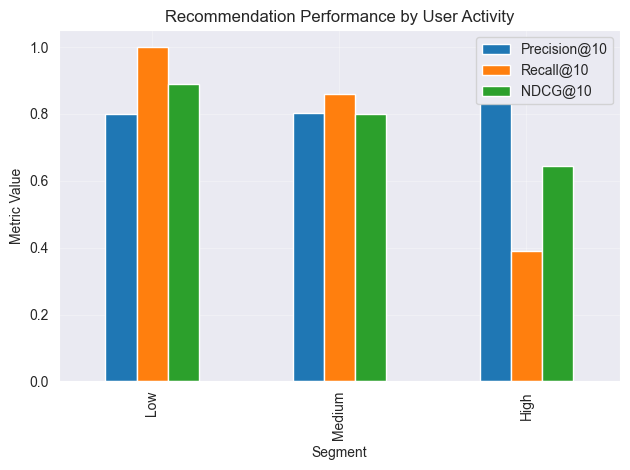

In [33]:
def analyze_by_user_activity():
    """Analyze recommendations by user activity levels"""
    user_counts = train_data['UserId'].value_counts().reset_index()
    user_counts.columns = ['UserId', 'RatingCount']

    # Define user segments
    user_counts['Segment'] = pd.qcut(user_counts['RatingCount'], 3, labels=['Low', 'Medium', 'High'])

    # Evaluate performance by segment
    results = []
    for segment in ['Low', 'Medium', 'High']:
        segment_users = user_counts[user_counts['Segment'] == segment]['UserId'].tolist()
        segment_test = test_data[test_data['UserId'].isin(segment_users)]

        if len(segment_test) > 0:
            metrics = evaluate_recommendations(instance.model, segment_test)
            results.append({
                'Segment': segment,
                'Precision@10': metrics['precision'][10],
                'Recall@10': metrics['recall'][10],
                'NDCG@10': metrics['ndcg'][10]
            })

    results_df = pd.DataFrame(results)
    print(results_df)

    # Plot results
    plt.figure(figsize=(10, 6))
    results_df.set_index('Segment').plot(kind='bar')
    plt.title('Recommendation Performance by User Activity')
    plt.ylabel('Metric Value')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

analyze_by_user_activity()

Cold Start Users (≤ 5 ratings):
{'ndcg': {10: np.float64(0.9055299059084638),
          20: np.float64(0.9055299059084638)},
 'precision': {10: 0.8341807909604522, 20: 0.8341807909604522},
 'recall': {10: 1.0, 20: 1.0}}

Established Users (> 20 ratings):
{'ndcg': {10: np.float64(0.7601962314715351),
          20: np.float64(0.8046150434424819)},
 'precision': {10: 0.8119806469075644, 20: 0.7688088482372051},
 'recall': {10: 0.7130310294494235, 20: 0.8806162304337838}}


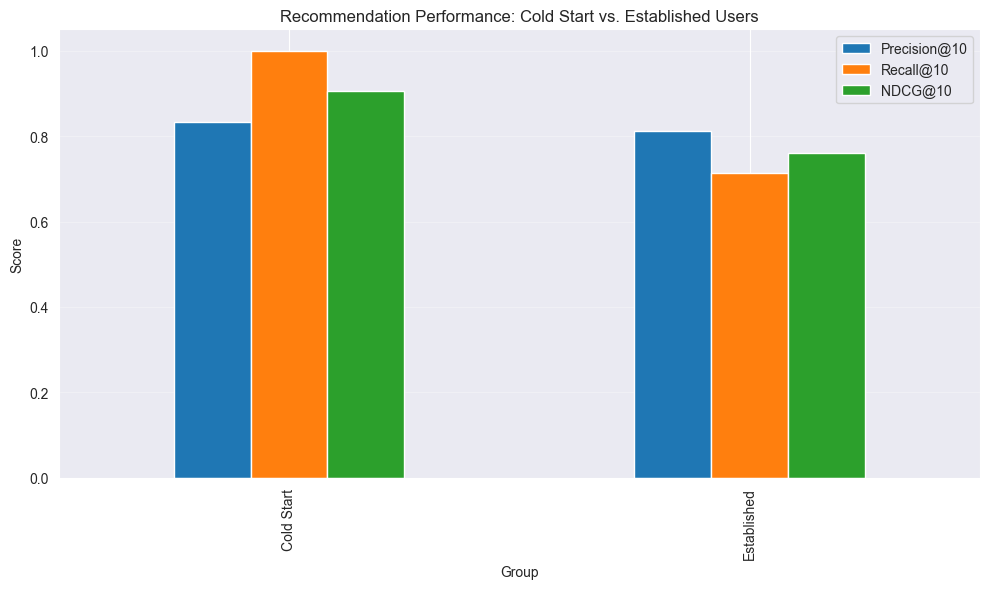

In [34]:
def analyze_cold_start_performance():
    """Analyze performance for cold-start users vs. established users"""
    user_ratings_count = train_data.groupby('UserId').size()
    cold_start_users = user_ratings_count[user_ratings_count <= 20].index
    established_users = user_ratings_count[user_ratings_count > 20].index

    cold_start_metrics = evaluate_recommendations(
        instance.model, test_data[test_data['UserId'].isin(cold_start_users)])
    established_metrics = evaluate_recommendations(
        instance.model, test_data[test_data['UserId'].isin(established_users)])

    print("Cold Start Users (≤ 5 ratings):")
    pprint(cold_start_metrics)
    print("\nEstablished Users (> 20 ratings):")
    pprint(established_metrics)

    # Visualization
    metrics_df = pd.DataFrame({
        'Group': ['Cold Start', 'Established'],
        'Precision@10': [cold_start_metrics['precision'][10], established_metrics['precision'][10]],
        'Recall@10': [cold_start_metrics['recall'][10], established_metrics['recall'][10]],
        'NDCG@10': [cold_start_metrics['ndcg'][10], established_metrics['ndcg'][10]]
    })

    metrics_df.set_index('Group').plot(kind='bar', figsize=(10, 6))
    plt.title('Recommendation Performance: Cold Start vs. Established Users')
    plt.ylabel('Score')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

analyze_cold_start_performance()